In [1]:
# =============================== #
#      Import Necessary Libraries  #
# =============================== #

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter
from PIL import Image
import os
from tqdm import tqdm
import random
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedShuffleSplit

# For logging with TensorBoard
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

# =============================== #
#           Define Device          #
# =============================== #

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# =============================== #
#         Define Class Names       #
# =============================== #

class_names = [
    'Background',    # (0)
    'Spleen',        # (1)
    'Right Kidney',  # (2)
    'Left Kidney',   # (3)
    'Gallbladder',   # (4)
    'Pancreas',      # (5)
    'Liver',         # (6)
    'Stomach',       # (7)
    'Aorta'          # (8)
]

num_classes = len(class_names)  # Should be 9

# =============================== #
#           Set Seed               #
# =============================== #

def set_seed(seed):
    """
    Sets the seed for reproducibility.
    
    Args:
        seed (int): Seed value.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

# =============================== #
#       Define Dataset Class      #
# =============================== #

class MedicalImageDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None, mask_transform=None):
        """
        Initializes the dataset with image and mask directories.
        
        Args:
            images_dir (str): Directory containing input images.
            masks_dir (str): Directory containing segmentation masks.
            transform (callable, optional): Transformations to apply to the images.
            mask_transform (callable, optional): Transformations to apply to the masks.
        """
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_names = sorted(os.listdir(images_dir))
        self.mask_names = sorted(os.listdir(masks_dir))
        assert len(self.image_names) == len(self.mask_names), "Number of images and masks do not match."
    
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.images_dir, self.image_names[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_names[idx])
        image = Image.open(img_path).convert('RGB')  # Ensure image is in RGB
        mask = Image.open(mask_path)
        
        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        # Convert mask to tensor with class indices
        mask = np.array(mask)
        mask = torch.from_numpy(mask).long()
        
        return image, mask

Using device: cuda


In [2]:
# =============================== #
#        Define Transformations   #
# =============================== #

# Define training image transformations with augmentations
train_image_transform = Compose([
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
              std=[0.229, 0.224, 0.225])
])

# Define validation image transformations without augmentations
val_image_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet statistics
              std=[0.229, 0.224, 0.225])
])

# Define mask transformations (if any)
mask_transform = Compose([
])

In [3]:
# =============================== #
#   Initialize Dataset and Loaders #
# =============================== #

# Replace these paths with your actual directories
images_dir = './train_images'  # e.g., './data/train_images'
masks_dir = './train_masks'    # e.g., './data/train_masks'

# Initialize the full dataset
full_dataset = MedicalImageDataset(
    images_dir=images_dir,
    masks_dir=masks_dir,
    transform=train_image_transform,  # Initial transformations (will be overridden after split)
    mask_transform=mask_transform
)

# Implement a Stratified Train-Validation Split
# Note: Stratified splitting for segmentation masks is non-trivial because each mask is multi-class.
# One approach is to sample based on the presence of classes.

def get_stratification_labels(dataset):
    """
    Generates stratification labels based on the presence of each class in the mask.
    
    Args:
        dataset (Dataset): The dataset to generate labels from.
    
    Returns:
        labels (list): Binary labels indicating the presence of at least one foreground class.
    """
    labels = []
    for _, mask in tqdm(dataset, desc="Generating stratification labels"):
        mask_np = mask.numpy()
        # Check if any foreground class is present
        foreground = 1 if np.any(mask_np > 0) else 0
        labels.append(foreground)
    return labels

# Generate stratification labels
labels = get_stratification_labels(full_dataset)

# Define the split (e.g., 80% train, 20% validation)
split_ratio = 0.8
split = StratifiedShuffleSplit(n_splits=1, test_size=1 - split_ratio, random_state=42)
train_idx, val_idx = next(split.split(np.zeros(len(labels)), labels))

# Create subsets
train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)

# Update transformations for subsets
# For training set, apply training transformations
train_dataset.dataset.transform = train_image_transform

# For validation set, apply validation transformations
val_dataset.dataset.transform = val_image_transform

# Initialize DataLoaders
batch_size = 16  # Adjust based on your system

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")



Generating stratification labels: 100%|██████████| 1631/1631 [00:18<00:00, 88.72it/s]

Number of training samples: 1304
Number of validation samples: 327


In [4]:
# =============================== #
#      Compute Class Weights      #
# =============================== #

def get_class_weights(loader, num_classes, device):
    """
    Computes class weights based on the frequency of each class in the dataset.
    
    Args:
        loader (DataLoader): DataLoader for the training dataset.
        num_classes (int): Number of classes.
        device (torch.device): Device to place the class weights tensor.
    
    Returns:
        class_weights (torch.Tensor): Tensor containing normalized class weights.
    """
    # Initialize an array to hold the counts for each class
    class_counts = np.zeros(num_classes)
    all_masks = []  # To store all masks

    print("Calculating class frequencies...")

    # Iterate over the DataLoader to accumulate class counts and collect all masks
    for _, masks in tqdm(loader, desc="Aggregating class counts"):
        masks = masks.numpy()
        all_masks.append(masks)
        for cls in range(num_classes):
            class_counts[cls] += np.sum(masks == cls)
    
    # Concatenate all masks and flatten
    all_masks = np.concatenate(all_masks, axis=0).flatten()

    print("Class Counts:", class_counts)
    
    # Verify that all classes are present
    unique_classes = np.unique(all_masks)
    missing_classes = set(range(num_classes)) - set(unique_classes)
    if missing_classes:
        print(f"Warning: The following classes are missing in the training dataset: {missing_classes}")
        # Assign a weight of zero to missing classes
        for cls in missing_classes:
            class_counts[cls] = 0

    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=all_masks
    )

    print("Computed Class Weights:", class_weights)
    
    # Handle missing classes by assigning zero weight
    class_weights = np.where(np.isin(np.arange(num_classes), unique_classes), class_weights, 0)

    print("Adjusted Class Weights (with zeros for missing classes):", class_weights)
    
    # Normalize class weights to sum to 1
    class_weights = class_weights / class_weights.sum()

    # Convert to torch tensor
    class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    print("Normalized Class Weights:", class_weights)
    
    return class_weights

# Compute class weights using only the training data
class_weights = get_class_weights(train_loader, num_classes, device)



Calculating class frequencies...


Aggregating class counts: 100%|██████████| 82/82 [00:09<00:00,  9.05it/s]


Class Counts: [3.15792948e+08 2.98860000e+06 1.32090100e+06 1.32673100e+06
 2.46931000e+05 1.49877900e+07 3.65606900e+06 8.07164000e+05
 7.08642000e+05]
Computed Class Weights: [1.20274228e-01 1.27088780e+01 2.87544281e+01 2.86280737e+01
 1.53815248e+02 2.53417968e+00 1.03886860e+01 4.70558064e+01
 5.35979421e+01]
Adjusted Class Weights (with zeros for missing classes): [1.20274228e-01 1.27088780e+01 2.87544281e+01 2.86280737e+01
 1.53815248e+02 2.53417968e+00 1.03886860e+01 4.70558064e+01
 5.35979421e+01]
Normalized Class Weights: tensor([3.5626e-04, 3.7644e-02, 8.5172e-02, 8.4798e-02, 4.5561e-01, 7.5064e-03,
        3.0772e-02, 1.3938e-01, 1.5876e-01], device='cuda:0')


In [5]:
# =============================== #
#        Define the U-Net Model    #
# =============================== #

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        
        # Encoder: Pre-trained ResNet34
        self.encoder = models.resnet34(pretrained=True)
        self.enc_layers = list(self.encoder.children())
        
        self.initial = nn.Sequential(*self.enc_layers[:3])  # Conv1, BN, ReLU
        self.maxpool = self.enc_layers[3]  # MaxPool
        
        self.encoder1 = self.enc_layers[4]  # Layer1
        self.encoder2 = self.enc_layers[5]  # Layer2
        self.encoder3 = self.enc_layers[6]  # Layer3
        self.encoder4 = self.enc_layers[7]  # Layer4
        
        # Decoder
        self.upconv4 = self.up_conv(512, 256)
        self.decoder4 = self.decoder_block(512, 256)
        
        self.upconv3 = self.up_conv(256, 128)
        self.decoder3 = self.decoder_block(256, 128)
        
        self.upconv2 = self.up_conv(128, 64)
        self.decoder2 = self.decoder_block(128, 64)
        
        self.upconv1 = self.up_conv(64, 64)
        self.decoder1 = self.decoder_block(128, 64)
        
        self.conv_last = nn.Conv2d(64, num_classes, kernel_size=1)
    
    def up_conv(self, in_channels, out_channels):
        """
        Defines an upsampling convolution.
        """
        return nn.ConvTranspose2d(
            in_channels, out_channels, kernel_size=2, stride=2
        )
    
    def decoder_block(self, in_channels, out_channels):
        """
        Defines a decoder block consisting of two convolutional layers.
        """
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        x0 = self.initial(x)        # Shape: (B, 64, H/2, W/2)
        x1 = self.maxpool(x0)       # Shape: (B, 64, H/4, W/4)
        x1 = self.encoder1(x1)      # Shape: (B, 64, H/4, W/4)
        x2 = self.encoder2(x1)      # Shape: (B, 128, H/8, W/8)
        x3 = self.encoder3(x2)      # Shape: (B, 256, H/16, W/16)
        x4 = self.encoder4(x3)      # Shape: (B, 512, H/32, W/32)
        
        # Decoder
        d4 = self.upconv4(x4)       # Shape: (B, 256, H/16, W/16)
        d4 = torch.cat((d4, x3), dim=1)  # Shape: (B, 512, H/16, W/16)
        d4 = self.decoder4(d4)      # Shape: (B, 256, H/16, W/16)
        
        d3 = self.upconv3(d4)       # Shape: (B, 128, H/8, W/8)
        d3 = torch.cat((d3, x2), dim=1)  # Shape: (B, 256, H/8, W/8)
        d3 = self.decoder3(d3)      # Shape: (B, 128, H/8, W/8)
        
        d2 = self.upconv2(d3)       # Shape: (B, 64, H/4, W/4)
        d2 = torch.cat((d2, x1), dim=1)  # Shape: (B, 128, H/4, W/4)
        d2 = self.decoder2(d2)      # Shape: (B, 64, H/4, W/4)
        
        d1 = self.upconv1(d2)       # Shape: (B, 64, H/2, W/2)
        d1 = torch.cat((d1, x0), dim=1)  # Shape: (B, 128, H/2, W/2)
        d1 = self.decoder1(d1)      # Shape: (B, 64, H/2, W/2)
        
        out = F.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=True)  # Shape: (B, 64, H, W)
        out = self.conv_last(out)    # Shape: (B, num_classes, H, W)
        
        return out

# Initialize the model
model = UNet(num_classes=num_classes)
model = model.to(device)

C:\Users\user\anaconda3\envs\DLA2\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\DLA2\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# =============================== #
#        Define Loss Functions    #
# =============================== #

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        """
        Computes Dice Loss.
        
        Args:
            inputs (torch.Tensor): Predicted logits with shape (batch_size, num_classes, H, W).
            targets (torch.Tensor): Ground truth labels with shape (batch_size, H, W).
        
        Returns:
            dice_loss (torch.Tensor): Dice loss value.
        """
        num_classes = inputs.size(1)
        inputs_soft = F.softmax(inputs, dim=1)  # Apply Softmax to get probabilities
        targets_onehot = F.one_hot(targets, num_classes=num_classes)  # Convert to one-hot encoding
        targets_onehot = targets_onehot.permute(0, 3, 1, 2).float()
        
        intersection = torch.sum(inputs_soft * targets_onehot, dim=(0, 2, 3))
        union = torch.sum(inputs_soft + targets_onehot, dim=(0, 2, 3))
        
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice.mean()
        
        return dice_loss

class DiceCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, smooth=1e-6):
        super(DiceCrossEntropyLoss, self).__init__()
        self.dice = DiceLoss(smooth)
        self.cross_entropy = nn.CrossEntropyLoss(weight=weight)
    
    def forward(self, inputs, targets):
        """
        Computes combined Dice + Cross-Entropy Loss.
        
        Args:
            inputs (torch.Tensor): Predicted logits with shape (batch_size, num_classes, H, W).
            targets (torch.Tensor): Ground truth labels with shape (batch_size, H, W).
        
        Returns:
            combined_loss (torch.Tensor): Combined loss value.
        """
        dice_loss = self.dice(inputs, targets)
        ce_loss = self.cross_entropy(inputs, targets)
        return dice_loss + ce_loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, logits=True, reduction='mean'):
        """
        Initializes the FocalLoss module.
        
        Args:
            alpha (torch.Tensor or list, optional): Weighting factor for each class.
            gamma (float): Focusing parameter to reduce the loss contribution from easy examples.
            logits (bool): If True, assumes that the input is raw logits. If False, assumes input is probability after softmax.
            reduction (str): Specifies the reduction to apply to the output: 'none' | 'mean' | 'sum'.
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.logits = logits
        self.reduction = reduction

        if isinstance(alpha, (list, tuple)):
            self.alpha = torch.tensor(alpha, dtype=torch.float)
        elif isinstance(alpha, float):
            self.alpha = torch.tensor([alpha] * num_classes, dtype=torch.float)  # Ensure num_classes is defined
        else:
            self.alpha = None

    def forward(self, inputs, targets):
        """
        Forward pass for Focal Loss.
        
        Args:
            inputs (torch.Tensor): Predicted logits with shape (batch_size, num_classes, H, W).
            targets (torch.Tensor): Ground truth labels with shape (batch_size, H, W).
        
        Returns:
            loss (torch.Tensor): Computed Focal Loss.
        """
        if self.logits:
            log_probs = F.log_softmax(inputs, dim=1)
            probs = F.softmax(inputs, dim=1)
        else:
            log_probs = torch.log(inputs)
            probs = inputs

        # Gather the log probabilities and probabilities of the true classes
        targets = targets.unsqueeze(1)  # Shape: (batch_size, 1, H, W)
        log_pt = log_probs.gather(1, targets).squeeze(1)  # Shape: (batch_size, H, W)
        pt = probs.gather(1, targets).squeeze(1)  # Shape: (batch_size, H, W)

        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            at = self.alpha[targets.squeeze(1)]  # Shape: (batch_size, H, W)
            log_pt = log_pt * at

        focal_term = (1 - pt) ** self.gamma
        loss = -focal_term * log_pt

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Initialize Loss Functions with Class Weights
dice_ce_loss = DiceCrossEntropyLoss()#weight=class_weights)

In [7]:
# =============================== #
#        Define IoU Calculation    #
# =============================== #

def calculate_iou(model, loader, num_classes, device):
    """
    Calculates the Intersection over Union (IoU) for each class across the entire dataset.
    
    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset.
        num_classes (int): Number of classes.
        device (torch.device): Device to perform computations on.
    
    Returns:
        mean_iou (float): Mean IoU across classes.
        iou_per_class (list): IoU for each class.
    """
    model.eval()
    intersection = torch.zeros(num_classes).to(device)
    union = torch.zeros(num_classes).to(device)
    
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Calculating IoU"):
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for cls in range(num_classes):
                pred_inds = (preds == cls)
                target_inds = (masks == cls)
                
                intersection[cls] += (pred_inds & target_inds).sum().float()
                union[cls] += (pred_inds | target_inds).sum().float()
    
    iou_per_class = []
    for cls in range(num_classes):
        if union[cls] == 0:
            iou = float('nan')  # If no ground truth for this class, ignore it
        else:
            iou = (intersection[cls] + 1e-6) / (union[cls] + 1e-6)
        iou_per_class.append(iou.item())
    
    # Compute mean IoU, ignoring NaNs
    valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
    if len(valid_ious) == 0:
        mean_iou = 0.0
    else:
        mean_iou = np.mean(valid_ious)
    
    return mean_iou, iou_per_class

In [8]:
# =============================== #
#        Define Training Function #
# =============================== #

import torch.optim as optim

def train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    scheduler=None,
    writer=None,
    save_path='unet_res34_16_noinv_inv_jitter.pt.pth',
    patience=10  # For early stopping
):
    """
    Trains the model and evaluates it on the validation set.
    
    Args:
        model (nn.Module): The model to train.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        num_epochs (int): Number of training epochs.
        device (torch.device): Device to train on.
        scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler. Defaults to None.
        writer (SummaryWriter, optional): TensorBoard writer. Defaults to None.
        save_path (str, optional): Path to save the best model. Defaults to 'best_model.pth'.
        patience (int, optional): Number of epochs to wait for improvement before stopping. Defaults to 10.
    
    Returns:
        model (nn.Module): Trained model.
    """
    best_mean_iou = 0.0
    best_epoch = 0
    epochs_no_improve = 0
    
    for epoch in range(1, num_epochs + 1):
        # Training Phase
        model.train()
        running_loss = 0.0
        
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} - Training"):
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # Calculate train IoU
        train_mean_iou, train_iou_per_class = calculate_iou(model, train_loader, num_classes, device)
        
        # Validation Phase
        mean_iou, iou_per_class = calculate_iou(model, val_loader, num_classes, device)
        
        # Calculate validation loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch}/{num_epochs} - Validation"):
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, masks)
                running_val_loss += loss.item() * images.size(0)
        
        val_loss = running_val_loss / len(val_loader.dataset)
        
        # Logging
        if writer:
            writer.add_scalar('Loss/Train', epoch_loss, epoch)
            writer.add_scalar('Loss/Val', val_loss, epoch)
            writer.add_scalar('Mean_IoU/Train', train_mean_iou, epoch)
            writer.add_scalar('Mean_IoU/Val', mean_iou, epoch)
            for cls in range(num_classes):
                writer.add_scalar(f'IoU/Train/{class_names[cls]}', train_iou_per_class[cls], epoch)
                writer.add_scalar(f'IoU/Val/{class_names[cls]}', iou_per_class[cls], epoch)
        
        # Print Metrics
        print(f"\nEpoch [{epoch}/{num_epochs}]")
        print(f"Train Loss: {epoch_loss:.4f}")
        print(f"Train Mean IoU: {train_mean_iou:.4f}")
        print("Train IoU per Class:")
        for cls in range(num_classes):
            print(f"  {class_names[cls]}: {train_iou_per_class[cls]:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Val Mean IoU: {mean_iou:.4f}")
        print("Val IoU per Class:")
        for cls in range(num_classes):
            print(f"  {class_names[cls]}: {iou_per_class[cls]:.4f}")
        print("-" * 30)
        
        # Scheduler step
        if scheduler and isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(mean_iou)
        elif scheduler:
            scheduler.step()
        
        # Check for improvement
        if mean_iou > best_mean_iou:
            best_mean_iou = mean_iou
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), save_path)
            print(f"Best model saved at epoch {epoch} with Mean IoU: {best_mean_iou:.4f}")
            print("-" * 30)
        else:
            epochs_no_improve += 1
        
        # Early Stopping
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    print(f"Training complete. Best Val Mean IoU: {best_mean_iou:.4f} at Epoch {best_epoch}.")
    
    # Load the best model for final evaluation
    model.load_state_dict(torch.load(save_path))
    model = model.to(device)
    model.eval()
    
    # Calculate and print metrics for the best model on the training set
    final_train_mean_iou, final_train_iou_per_class = calculate_iou(model, train_loader, num_classes, device)
    final_train_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(train_loader, desc="Evaluating best model on training set"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            final_train_loss += loss.item() * images.size(0)
    
    final_train_loss /= len(train_loader.dataset)
    
    print("\nBest Model - Training Set Results:")
    print(f"Best Train Loss: {final_train_loss:.4f}")
    print(f"Best Train Mean IoU: {final_train_mean_iou:.4f}")
    print("Best Train IoU per Class:")
    for cls in range(num_classes):
        print(f"  {class_names[cls]}: {final_train_iou_per_class[cls]:.4f}")
    print("-" * 30)

    # Calculate and print metrics for the best model on the validation set
    final_val_mean_iou, final_val_iou_per_class = calculate_iou(model, val_loader, num_classes, device)
    final_val_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating best model on validation set"):
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            final_val_loss += loss.item() * images.size(0)
    
    final_val_loss /= len(val_loader.dataset)
    
    print("\nBest Model - Validation Set Results:")
    print(f"Best Val Loss: {final_val_loss:.4f}")
    print(f"Best Val Mean IoU: {final_val_mean_iou:.4f}")
    print("Best Val IoU per Class:")
    for cls in range(num_classes):
        print(f"  {class_names[cls]}: {final_val_iou_per_class[cls]:.4f}")
    print("-" * 30)
    
    return model



In [9]:
# =============================== #
#    Visualize Sample Predictions #
# =============================== #

def visualize_predictions(model, loader, device, num_images=5):
    """
    Visualizes predictions alongside ground truth masks.
    
    Args:
        model (nn.Module): The trained model.
        loader (DataLoader): DataLoader for the dataset to visualize.
        device (torch.device): Device to perform computations on.
        num_images (int): Number of images to visualize.
    
    Returns:
        None
    """
    model.eval()
    images_so_far = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            
            for i in range(images.size(0)):
                images_so_far += 1
                image = images[i].cpu().numpy().transpose((1, 2, 0))
                image = np.clip(image * np.array([0.229, 0.224, 0.225]) + 
                                np.array([0.485, 0.456, 0.406]), 0, 1)
                mask = masks[i].cpu().numpy()
                pred = preds[i].cpu().numpy()
                
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(image)
                axs[0].set_title('Input Image')
                axs[0].axis('off')
                
                axs[1].imshow(mask, cmap='jet', vmin=0, vmax=num_classes-1)
                axs[1].set_title('Ground Truth')
                axs[1].axis('off')
                
                axs[2].imshow(pred, cmap='jet', vmin=0, vmax=num_classes-1)
                axs[2].set_title('Predicted Mask')
                axs[2].axis('off')
                
                plt.show()
                
                if images_so_far >= num_images:
                    return



In [10]:
# =============================== #
#    Model Initialization Function #
# =============================== #

def get_unet_resnet34(num_classes, encoder_weights='imagenet', bilinear=True):
    """
    Initializes a U-Net model with a ResNet34 encoder.
    
    Args:
        num_classes (int): Number of output classes.
        encoder_weights (str): Pre-training weights for the encoder. Options: 'imagenet', None.
        bilinear (bool): If True, uses bilinear upsampling in the decoder.
    
    Returns:
        model (nn.Module): Initialized U-Net model.
    """
    model = UNet(num_classes=num_classes)
    return model

In [11]:
# =============================== #
#        Initialize TensorBoard    #
# =============================== #

# Initialize TensorBoard writer
writer = SummaryWriter('runs/unet_resnet34_experiment')

In [12]:
# =============================== #
#         Define Optimizer & Scheduler #
# =============================== #

# Function to initialize optimizer and scheduler
def initialize_optimizer_scheduler(model, stage='stage1'):
    """
    Initializes the optimizer and scheduler based on the training stage.
    
    Args:
        model (nn.Module): The model to optimize.
        stage (str): The current training stage ('stage1', 'stage2', or 'stage3').
    
    Returns:
        optimizer (torch.optim.Optimizer): Initialized optimizer.
        scheduler (torch.optim.lr_scheduler): Initialized scheduler.
    """
    if stage == 'stage1':
        # Stage 1: Higher learning rate for initial training
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
    elif stage == 'stage2':
        # Stage 2: Intermediate learning rate for continued training
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
    elif stage == 'stage3':
        # Stage 3: Lower learning rate for fine-tuning
        optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=1e-5)
    else:
        raise ValueError("Invalid stage. Choose 'stage1', 'stage2', or 'stage3'.")
    
    # Initialize the ReduceLROnPlateau scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',  # Since we are maximizing IoU
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    return optimizer, scheduler

In [13]:
# =============================== #
#          Training Stages         #
# =============================== #

# ------------------------------ #
#  Stage 1: Dice + Cross-Entropy #
# ------------------------------ #

num_epochs_stage1 = 30  # Adjust based on your needs

print("\nStarting Stage 1: Training with Dice + Cross-Entropy Loss")
optimizer_stage1, scheduler_stage1 = initialize_optimizer_scheduler(model, stage='stage1')
model = train_model(
    model=model,
    criterion=dice_ce_loss,
    optimizer=optimizer_stage1,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_stage1,
    device=device,
    scheduler=scheduler_stage1,  # Using ReduceLROnPlateau
    writer=writer,
    save_path='unet_res34_16_noinv_inv_jitter_stage1.pth',
    patience=10
)


Starting Stage 1: Training with Dice + Cross-Entropy Loss


Epoch 1/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.35it/s]



Epoch [1/30]
Train Loss: 2.6268
Train Mean IoU: 0.1934
Train IoU per Class:
  Background: 0.9299
  Spleen: 0.2099
  Right Kidney: 0.0001
  Left Kidney: 0.0148
  Gallbladder: 0.0001
  Pancreas: 0.5813
  Liver: 0.0046
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 2.1817
Val Mean IoU: 0.1898
Val IoU per Class:
  Background: 0.9312
  Spleen: 0.1902
  Right Kidney: 0.0000
  Left Kidney: 0.0148
  Gallbladder: 0.0001
  Pancreas: 0.5673
  Liver: 0.0049
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 1 with Mean IoU: 0.1898
------------------------------


Epoch 2/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s]



Epoch [2/30]
Train Loss: 2.0881
Train Mean IoU: 0.2695
Train IoU per Class:
  Background: 0.9804
  Spleen: 0.4202
  Right Kidney: 0.0037
  Left Kidney: 0.0021
  Gallbladder: 0.0000
  Pancreas: 0.7876
  Liver: 0.2313
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 1.9568
Val Mean IoU: 0.2659
Val IoU per Class:
  Background: 0.9807
  Spleen: 0.4054
  Right Kidney: 0.0040
  Left Kidney: 0.0023
  Gallbladder: 0.0000
  Pancreas: 0.7741
  Liver: 0.2267
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 2 with Mean IoU: 0.2659
------------------------------


Epoch 3/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s]



Epoch [3/30]
Train Loss: 1.8409
Train Mean IoU: 0.3525
Train IoU per Class:
  Background: 0.9830
  Spleen: 0.7681
  Right Kidney: 0.0027
  Left Kidney: 0.0538
  Gallbladder: 0.0000
  Pancreas: 0.8236
  Liver: 0.5413
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 1.7124
Val Mean IoU: 0.3462
Val IoU per Class:
  Background: 0.9832
  Spleen: 0.7556
  Right Kidney: 0.0032
  Left Kidney: 0.0499
  Gallbladder: 0.0000
  Pancreas: 0.8103
  Liver: 0.5132
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 3 with Mean IoU: 0.3462
------------------------------


Epoch 4/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s]



Epoch [4/30]
Train Loss: 1.6243
Train Mean IoU: 0.5117
Train IoU per Class:
  Background: 0.9855
  Spleen: 0.7817
  Right Kidney: 0.7061
  Left Kidney: 0.3900
  Gallbladder: 0.0000
  Pancreas: 0.9111
  Liver: 0.8305
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 1.4846
Val Mean IoU: 0.5049
Val IoU per Class:
  Background: 0.9855
  Spleen: 0.7694
  Right Kidney: 0.6952
  Left Kidney: 0.3796
  Gallbladder: 0.0000
  Pancreas: 0.9019
  Liver: 0.8126
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 4 with Mean IoU: 0.5049
------------------------------


Epoch 5/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.28it/s]



Epoch [5/30]
Train Loss: 1.4370
Train Mean IoU: 0.5595
Train IoU per Class:
  Background: 0.9853
  Spleen: 0.8032
  Right Kidney: 0.7978
  Left Kidney: 0.7073
  Gallbladder: 0.0000
  Pancreas: 0.9060
  Liver: 0.8362
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 1.3488
Val Mean IoU: 0.5495
Val IoU per Class:
  Background: 0.9853
  Spleen: 0.7865
  Right Kidney: 0.7745
  Left Kidney: 0.6834
  Gallbladder: 0.0000
  Pancreas: 0.8976
  Liver: 0.8185
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 5 with Mean IoU: 0.5495
------------------------------


Epoch 6/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.45it/s]



Epoch [6/30]
Train Loss: 1.2710
Train Mean IoU: 0.5651
Train IoU per Class:
  Background: 0.9911
  Spleen: 0.7542
  Right Kidney: 0.8609
  Left Kidney: 0.6612
  Gallbladder: 0.0000
  Pancreas: 0.9417
  Liver: 0.8773
  Stomach: 0.0000
  Aorta: 0.0000
Val Loss: 1.1838
Val Mean IoU: 0.5545
Val IoU per Class:
  Background: 0.9905
  Spleen: 0.7289
  Right Kidney: 0.8499
  Left Kidney: 0.6433
  Gallbladder: 0.0000
  Pancreas: 0.9288
  Liver: 0.8490
  Stomach: 0.0000
  Aorta: 0.0000
------------------------------
Best model saved at epoch 6 with Mean IoU: 0.5545
------------------------------


Epoch 7/30 - Validation: 100%|██████████| 21/21 [00:03<00:00,  7.00it/s]



Epoch [7/30]
Train Loss: 1.1333
Train Mean IoU: 0.6744
Train IoU per Class:
  Background: 0.9927
  Spleen: 0.8779
  Right Kidney: 0.8698
  Left Kidney: 0.8808
  Gallbladder: 0.0000
  Pancreas: 0.9492
  Liver: 0.9048
  Stomach: 0.5397
  Aorta: 0.0545
Val Loss: 1.0775
Val Mean IoU: 0.6638
Val IoU per Class:
  Background: 0.9920
  Spleen: 0.8647
  Right Kidney: 0.8610
  Left Kidney: 0.8678
  Gallbladder: 0.0000
  Pancreas: 0.9369
  Liver: 0.8741
  Stomach: 0.5280
  Aorta: 0.0498
------------------------------
Best model saved at epoch 7 with Mean IoU: 0.6638
------------------------------


Epoch 8/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.35it/s]



Epoch [8/30]
Train Loss: 0.9977
Train Mean IoU: 0.7741
Train IoU per Class:
  Background: 0.9926
  Spleen: 0.9314
  Right Kidney: 0.8726
  Left Kidney: 0.8621
  Gallbladder: 0.0000
  Pancreas: 0.9458
  Liver: 0.9171
  Stomach: 0.8066
  Aorta: 0.6391
Val Loss: 0.9532
Val Mean IoU: 0.7558
Val IoU per Class:
  Background: 0.9919
  Spleen: 0.9157
  Right Kidney: 0.8580
  Left Kidney: 0.8490
  Gallbladder: 0.0000
  Pancreas: 0.9332
  Liver: 0.8787
  Stomach: 0.7967
  Aorta: 0.5795
------------------------------
Best model saved at epoch 8 with Mean IoU: 0.7558
------------------------------


Epoch 9/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s]



Epoch [9/30]
Train Loss: 0.8758
Train Mean IoU: 0.7759
Train IoU per Class:
  Background: 0.9933
  Spleen: 0.9452
  Right Kidney: 0.8686
  Left Kidney: 0.8518
  Gallbladder: 0.0000
  Pancreas: 0.9529
  Liver: 0.9328
  Stomach: 0.7766
  Aorta: 0.6614
Val Loss: 0.8384
Val Mean IoU: 0.7584
Val IoU per Class:
  Background: 0.9924
  Spleen: 0.9305
  Right Kidney: 0.8578
  Left Kidney: 0.8399
  Gallbladder: 0.0000
  Pancreas: 0.9398
  Liver: 0.8993
  Stomach: 0.7600
  Aorta: 0.6058
------------------------------
Best model saved at epoch 9 with Mean IoU: 0.7584
------------------------------


Epoch 10/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.60it/s]



Epoch [10/30]
Train Loss: 0.7661
Train Mean IoU: 0.7938
Train IoU per Class:
  Background: 0.9944
  Spleen: 0.9432
  Right Kidney: 0.9021
  Left Kidney: 0.8824
  Gallbladder: 0.0000
  Pancreas: 0.9563
  Liver: 0.9346
  Stomach: 0.7880
  Aorta: 0.7431
Val Loss: 0.7498
Val Mean IoU: 0.7737
Val IoU per Class:
  Background: 0.9933
  Spleen: 0.9259
  Right Kidney: 0.8877
  Left Kidney: 0.8655
  Gallbladder: 0.0000
  Pancreas: 0.9425
  Liver: 0.8966
  Stomach: 0.7740
  Aorta: 0.6774
------------------------------
Best model saved at epoch 10 with Mean IoU: 0.7737
------------------------------


Epoch 11/30 - Validation: 100%|██████████| 21/21 [00:03<00:00,  6.92it/s]



Epoch [11/30]
Train Loss: 0.6653
Train Mean IoU: 0.8139
Train IoU per Class:
  Background: 0.9951
  Spleen: 0.9535
  Right Kidney: 0.9228
  Left Kidney: 0.9165
  Gallbladder: 0.0090
  Pancreas: 0.9520
  Liver: 0.9401
  Stomach: 0.8618
  Aorta: 0.7744
Val Loss: 0.6256
Val Mean IoU: 0.7905
Val IoU per Class:
  Background: 0.9938
  Spleen: 0.9379
  Right Kidney: 0.9032
  Left Kidney: 0.8989
  Gallbladder: 0.0089
  Pancreas: 0.9367
  Liver: 0.9049
  Stomach: 0.8420
  Aorta: 0.6883
------------------------------
Best model saved at epoch 11 with Mean IoU: 0.7905
------------------------------


Epoch 12/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.18it/s]



Epoch [12/30]
Train Loss: 0.5745
Train Mean IoU: 0.8774
Train IoU per Class:
  Background: 0.9945
  Spleen: 0.9339
  Right Kidney: 0.9135
  Left Kidney: 0.8624
  Gallbladder: 0.7395
  Pancreas: 0.9626
  Liver: 0.9385
  Stomach: 0.8417
  Aorta: 0.7096
Val Loss: 0.5453
Val Mean IoU: 0.8507
Val IoU per Class:
  Background: 0.9933
  Spleen: 0.9177
  Right Kidney: 0.8953
  Left Kidney: 0.8463
  Gallbladder: 0.7087
  Pancreas: 0.9466
  Liver: 0.8983
  Stomach: 0.8224
  Aorta: 0.6279
------------------------------
Best model saved at epoch 12 with Mean IoU: 0.8507
------------------------------


Epoch 13/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s]



Epoch [13/30]
Train Loss: 0.4833
Train Mean IoU: 0.9095
Train IoU per Class:
  Background: 0.9961
  Spleen: 0.9560
  Right Kidney: 0.9358
  Left Kidney: 0.9302
  Gallbladder: 0.7304
  Pancreas: 0.9642
  Liver: 0.9478
  Stomach: 0.9153
  Aorta: 0.8101
Val Loss: 0.4686
Val Mean IoU: 0.8805
Val IoU per Class:
  Background: 0.9947
  Spleen: 0.9390
  Right Kidney: 0.9124
  Left Kidney: 0.9086
  Gallbladder: 0.7024
  Pancreas: 0.9483
  Liver: 0.9023
  Stomach: 0.8852
  Aorta: 0.7312
------------------------------
Best model saved at epoch 13 with Mean IoU: 0.8805
------------------------------


Epoch 14/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.02it/s]



Epoch [14/30]
Train Loss: 0.4020
Train Mean IoU: 0.9142
Train IoU per Class:
  Background: 0.9961
  Spleen: 0.9510
  Right Kidney: 0.9327
  Left Kidney: 0.9178
  Gallbladder: 0.7745
  Pancreas: 0.9658
  Liver: 0.9433
  Stomach: 0.9197
  Aorta: 0.8270
Val Loss: 0.3951
Val Mean IoU: 0.8844
Val IoU per Class:
  Background: 0.9947
  Spleen: 0.9340
  Right Kidney: 0.9074
  Left Kidney: 0.8960
  Gallbladder: 0.7311
  Pancreas: 0.9492
  Liver: 0.9065
  Stomach: 0.8895
  Aorta: 0.7509
------------------------------
Best model saved at epoch 14 with Mean IoU: 0.8844
------------------------------


Epoch 15/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.36it/s]



Epoch [15/30]
Train Loss: 0.3370
Train Mean IoU: 0.9191
Train IoU per Class:
  Background: 0.9961
  Spleen: 0.9584
  Right Kidney: 0.9303
  Left Kidney: 0.9349
  Gallbladder: 0.8208
  Pancreas: 0.9652
  Liver: 0.9410
  Stomach: 0.9128
  Aorta: 0.8124
Val Loss: 0.3349
Val Mean IoU: 0.8859
Val IoU per Class:
  Background: 0.9946
  Spleen: 0.9407
  Right Kidney: 0.9023
  Left Kidney: 0.9102
  Gallbladder: 0.7739
  Pancreas: 0.9486
  Liver: 0.8928
  Stomach: 0.8802
  Aorta: 0.7298
------------------------------
Best model saved at epoch 15 with Mean IoU: 0.8859
------------------------------


Epoch 16/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.31it/s]



Epoch [16/30]
Train Loss: 0.2849
Train Mean IoU: 0.9184
Train IoU per Class:
  Background: 0.9960
  Spleen: 0.9422
  Right Kidney: 0.9307
  Left Kidney: 0.9186
  Gallbladder: 0.8380
  Pancreas: 0.9638
  Liver: 0.9356
  Stomach: 0.9045
  Aorta: 0.8363
Val Loss: 0.3046
Val Mean IoU: 0.8803
Val IoU per Class:
  Background: 0.9944
  Spleen: 0.9212
  Right Kidney: 0.9032
  Left Kidney: 0.8959
  Gallbladder: 0.7671
  Pancreas: 0.9442
  Liver: 0.8847
  Stomach: 0.8747
  Aorta: 0.7378
------------------------------


Epoch 17/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.23it/s]



Epoch [17/30]
Train Loss: 0.2754
Train Mean IoU: 0.9072
Train IoU per Class:
  Background: 0.9952
  Spleen: 0.9473
  Right Kidney: 0.9250
  Left Kidney: 0.9076
  Gallbladder: 0.8071
  Pancreas: 0.9553
  Liver: 0.9299
  Stomach: 0.8953
  Aorta: 0.8017
Val Loss: 0.2592
Val Mean IoU: 0.8814
Val IoU per Class:
  Background: 0.9942
  Spleen: 0.9363
  Right Kidney: 0.9056
  Left Kidney: 0.8933
  Gallbladder: 0.7738
  Pancreas: 0.9422
  Liver: 0.8917
  Stomach: 0.8741
  Aorta: 0.7215
------------------------------


Epoch 18/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.10it/s]



Epoch [18/30]
Train Loss: 0.2190
Train Mean IoU: 0.9145
Train IoU per Class:
  Background: 0.9956
  Spleen: 0.9512
  Right Kidney: 0.9278
  Left Kidney: 0.9253
  Gallbladder: 0.8054
  Pancreas: 0.9610
  Liver: 0.9429
  Stomach: 0.9036
  Aorta: 0.8176
Val Loss: 0.2197
Val Mean IoU: 0.8880
Val IoU per Class:
  Background: 0.9944
  Spleen: 0.9330
  Right Kidney: 0.9087
  Left Kidney: 0.9069
  Gallbladder: 0.7739
  Pancreas: 0.9454
  Liver: 0.9051
  Stomach: 0.8808
  Aorta: 0.7442
------------------------------
Best model saved at epoch 18 with Mean IoU: 0.8880
------------------------------


Epoch 19/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.22it/s]



Epoch [19/30]
Train Loss: 0.1814
Train Mean IoU: 0.9256
Train IoU per Class:
  Background: 0.9963
  Spleen: 0.9586
  Right Kidney: 0.9388
  Left Kidney: 0.9341
  Gallbladder: 0.8395
  Pancreas: 0.9662
  Liver: 0.9472
  Stomach: 0.9167
  Aorta: 0.8332
Val Loss: 0.1871
Val Mean IoU: 0.8927
Val IoU per Class:
  Background: 0.9949
  Spleen: 0.9425
  Right Kidney: 0.9135
  Left Kidney: 0.9102
  Gallbladder: 0.7959
  Pancreas: 0.9500
  Liver: 0.9041
  Stomach: 0.8875
  Aorta: 0.7359
------------------------------
Best model saved at epoch 19 with Mean IoU: 0.8927
------------------------------


Epoch 20/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.09it/s]



Epoch [20/30]
Train Loss: 0.1563
Train Mean IoU: 0.9396
Train IoU per Class:
  Background: 0.9967
  Spleen: 0.9609
  Right Kidney: 0.9444
  Left Kidney: 0.9411
  Gallbladder: 0.8781
  Pancreas: 0.9682
  Liver: 0.9570
  Stomach: 0.9321
  Aorta: 0.8778
Val Loss: 0.1587
Val Mean IoU: 0.9032
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9422
  Right Kidney: 0.9171
  Left Kidney: 0.9142
  Gallbladder: 0.8232
  Pancreas: 0.9504
  Liver: 0.9117
  Stomach: 0.8973
  Aorta: 0.7771
------------------------------
Best model saved at epoch 20 with Mean IoU: 0.9032
------------------------------


Epoch 21/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]



Epoch [21/30]
Train Loss: 0.1325
Train Mean IoU: 0.9407
Train IoU per Class:
  Background: 0.9968
  Spleen: 0.9609
  Right Kidney: 0.9485
  Left Kidney: 0.9420
  Gallbladder: 0.8799
  Pancreas: 0.9691
  Liver: 0.9567
  Stomach: 0.9303
  Aorta: 0.8819
Val Loss: 0.1454
Val Mean IoU: 0.9001
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9426
  Right Kidney: 0.9173
  Left Kidney: 0.9116
  Gallbladder: 0.8139
  Pancreas: 0.9506
  Liver: 0.9105
  Stomach: 0.8898
  Aorta: 0.7697
------------------------------


Epoch 22/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.23it/s]



Epoch [22/30]
Train Loss: 0.1161
Train Mean IoU: 0.9339
Train IoU per Class:
  Background: 0.9964
  Spleen: 0.9486
  Right Kidney: 0.9459
  Left Kidney: 0.9388
  Gallbladder: 0.8587
  Pancreas: 0.9667
  Liver: 0.9584
  Stomach: 0.9229
  Aorta: 0.8685
Val Loss: 0.1391
Val Mean IoU: 0.8966
Val IoU per Class:
  Background: 0.9947
  Spleen: 0.9290
  Right Kidney: 0.9158
  Left Kidney: 0.9113
  Gallbladder: 0.8158
  Pancreas: 0.9478
  Liver: 0.9122
  Stomach: 0.8827
  Aorta: 0.7604
------------------------------


Epoch 23/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.41it/s]



Epoch [23/30]
Train Loss: 0.1052
Train Mean IoU: 0.9420
Train IoU per Class:
  Background: 0.9969
  Spleen: 0.9632
  Right Kidney: 0.9505
  Left Kidney: 0.9438
  Gallbladder: 0.8743
  Pancreas: 0.9688
  Liver: 0.9605
  Stomach: 0.9290
  Aorta: 0.8913
Val Loss: 0.1264
Val Mean IoU: 0.8990
Val IoU per Class:
  Background: 0.9950
  Spleen: 0.9408
  Right Kidney: 0.9181
  Left Kidney: 0.9138
  Gallbladder: 0.8060
  Pancreas: 0.9493
  Liver: 0.9141
  Stomach: 0.8852
  Aorta: 0.7687
------------------------------


Epoch 24/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.39it/s]



Epoch [24/30]
Train Loss: 0.0916
Train Mean IoU: 0.9448
Train IoU per Class:
  Background: 0.9970
  Spleen: 0.9655
  Right Kidney: 0.9519
  Left Kidney: 0.9478
  Gallbladder: 0.8797
  Pancreas: 0.9709
  Liver: 0.9581
  Stomach: 0.9392
  Aorta: 0.8936
Val Loss: 0.1185
Val Mean IoU: 0.8999
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9436
  Right Kidney: 0.9167
  Left Kidney: 0.9149
  Gallbladder: 0.8096
  Pancreas: 0.9505
  Liver: 0.9077
  Stomach: 0.8917
  Aorta: 0.7693
------------------------------


Epoch 25/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.23it/s]



Epoch [25/30]
Train Loss: 0.0866
Train Mean IoU: 0.9381
Train IoU per Class:
  Background: 0.9966
  Spleen: 0.9638
  Right Kidney: 0.9445
  Left Kidney: 0.9363
  Gallbladder: 0.8717
  Pancreas: 0.9662
  Liver: 0.9561
  Stomach: 0.9355
  Aorta: 0.8722
Val Loss: 0.1140
Val Mean IoU: 0.8976
Val IoU per Class:
  Background: 0.9948
  Spleen: 0.9418
  Right Kidney: 0.9130
  Left Kidney: 0.9095
  Gallbladder: 0.8234
  Pancreas: 0.9479
  Liver: 0.9089
  Stomach: 0.8906
  Aorta: 0.7481
------------------------------


Epoch 26/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.32it/s]



Epoch [26/30]
Train Loss: 0.0822
Train Mean IoU: 0.9460
Train IoU per Class:
  Background: 0.9970
  Spleen: 0.9664
  Right Kidney: 0.9498
  Left Kidney: 0.9488
  Gallbladder: 0.8893
  Pancreas: 0.9704
  Liver: 0.9596
  Stomach: 0.9411
  Aorta: 0.8912
Val Loss: 0.1081
Val Mean IoU: 0.9024
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9434
  Right Kidney: 0.9183
  Left Kidney: 0.9139
  Gallbladder: 0.8246
  Pancreas: 0.9513
  Liver: 0.9102
  Stomach: 0.8927
  Aorta: 0.7717
------------------------------


Epoch 27/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.30it/s]



Epoch [27/30]
Train Loss: 0.0740
Train Mean IoU: 0.9562
Train IoU per Class:
  Background: 0.9974
  Spleen: 0.9699
  Right Kidney: 0.9568
  Left Kidney: 0.9544
  Gallbladder: 0.9225
  Pancreas: 0.9729
  Liver: 0.9670
  Stomach: 0.9514
  Aorta: 0.9139
Val Loss: 0.1016
Val Mean IoU: 0.9069
Val IoU per Class:
  Background: 0.9953
  Spleen: 0.9448
  Right Kidney: 0.9186
  Left Kidney: 0.9154
  Gallbladder: 0.8498
  Pancreas: 0.9522
  Liver: 0.9144
  Stomach: 0.8947
  Aorta: 0.7767
------------------------------
Best model saved at epoch 27 with Mean IoU: 0.9069
------------------------------


Epoch 28/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.35it/s]



Epoch [28/30]
Train Loss: 0.0673
Train Mean IoU: 0.9573
Train IoU per Class:
  Background: 0.9975
  Spleen: 0.9702
  Right Kidney: 0.9582
  Left Kidney: 0.9555
  Gallbladder: 0.9206
  Pancreas: 0.9738
  Liver: 0.9693
  Stomach: 0.9535
  Aorta: 0.9169
Val Loss: 0.1025
Val Mean IoU: 0.9062
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9451
  Right Kidney: 0.9183
  Left Kidney: 0.9161
  Gallbladder: 0.8513
  Pancreas: 0.9520
  Liver: 0.9137
  Stomach: 0.8934
  Aorta: 0.7708
------------------------------


Epoch 29/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.12it/s]



Epoch [29/30]
Train Loss: 0.0690
Train Mean IoU: 0.9608
Train IoU per Class:
  Background: 0.9976
  Spleen: 0.9719
  Right Kidney: 0.9600
  Left Kidney: 0.9590
  Gallbladder: 0.9342
  Pancreas: 0.9745
  Liver: 0.9707
  Stomach: 0.9555
  Aorta: 0.9241
Val Loss: 0.0997
Val Mean IoU: 0.9065
Val IoU per Class:
  Background: 0.9953
  Spleen: 0.9450
  Right Kidney: 0.9174
  Left Kidney: 0.9158
  Gallbladder: 0.8475
  Pancreas: 0.9523
  Liver: 0.9147
  Stomach: 0.8933
  Aorta: 0.7772
------------------------------


Epoch 30/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.55it/s]
C:\Users\user\AppData\Local\Temp\ipykernel_6392\4050040428.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment


Epoch [30/30]
Train Loss: 0.0598
Train Mean IoU: 0.9630
Train IoU per Class:
  Background: 0.9977
  Spleen: 0.9718
  Right Kidney: 0.9623
  Left Kidney: 0.9606
  Gallbladder: 0.9411
  Pancreas: 0.9755
  Liver: 0.9711
  Stomach: 0.9591
  Aorta: 0.9280
Val Loss: 0.0980
Val Mean IoU: 0.9075
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9433
  Right Kidney: 0.9179
  Left Kidney: 0.9150
  Gallbladder: 0.8557
  Pancreas: 0.9521
  Liver: 0.9152
  Stomach: 0.8947
  Aorta: 0.7783
------------------------------
Best model saved at epoch 30 with Mean IoU: 0.9075
------------------------------
Training complete. Best Val Mean IoU: 0.9075 at Epoch 30.


Evaluating best model on training set: 100%|██████████| 82/82 [00:11<00:00,  7.15it/s]



Best Model - Training Set Results:
Best Train Loss: 0.0576
Best Train Mean IoU: 0.9630
Best Train IoU per Class:
  Background: 0.9977
  Spleen: 0.9718
  Right Kidney: 0.9623
  Left Kidney: 0.9606
  Gallbladder: 0.9411
  Pancreas: 0.9755
  Liver: 0.9711
  Stomach: 0.9591
  Aorta: 0.9280
------------------------------


Evaluating best model on validation set: 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]


Best Model - Validation Set Results:
Best Val Loss: 0.0980
Best Val Mean IoU: 0.9075
Best Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9433
  Right Kidney: 0.9179
  Left Kidney: 0.9150
  Gallbladder: 0.8557
  Pancreas: 0.9521
  Liver: 0.9152
  Stomach: 0.8947
  Aorta: 0.7783
------------------------------


In [14]:
# ------------------------------ #
#          Phase 2: Fine-Tuning on Underperforming Classes    #
# ------------------------------ #

print("\nStarting Phase 2: Fine-Tuning with Focal Loss to Improve Underperforming Classes")

# Load the best model from Phase 1
phase1_save_path = 'unet_res34_16_noinv_inv_jitter_stage1.pth'  # Ensure this path matches where Phase 1 saved the model
model.load_state_dict(torch.load(phase1_save_path, map_location=device))
model = model.to(device)
model.train()  # Set model to training mode
# Identify underperforming classes based on Phase 1 validation results
# Example: Classes 4 (Gallbladder) and 8 (Aorta) are underperforming
underperforming_classes = [4, 8]  # Modify this list based on actual validation results

# Create a copy of the original class weights
custom_alpha = class_weights.clone()

# Define weight multipliers for underperforming classes
alpha_multipliers = {
    4: 1.0,  # Gallbladder
    8: 1.0   # Aorta
}

# Apply multipliers to the specified classes
for cls, multiplier in alpha_multipliers.items():
    custom_alpha[cls] = custom_alpha[cls] * multiplier

# Normalize the custom alpha weights to ensure they sum to 1
custom_alpha = custom_alpha / custom_alpha.sum()

# Move custom_alpha to the appropriate device
custom_alpha = custom_alpha.to(device)

print("Updated Class Weights (Alpha):", custom_alpha)

# Initialize Focal Loss with updated alpha
focal_loss_phase2 = FocalLoss(alpha=custom_alpha, gamma=1, logits=True, reduction='mean').to(device) #

# Initialize optimizer and scheduler for Phase 2
optimizer_phase2, scheduler_phase2 = initialize_optimizer_scheduler(model, stage='stage2')

# Define the number of epochs for Phase 2
num_epochs_phase2 = 30  # Adjust based on your requirements

# Train with Focal Loss focusing on underperforming classes
model = train_model(
    model=model,
    criterion=focal_loss_phase2,
    optimizer=optimizer_phase2,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs_phase2,
    device=device,
    scheduler=scheduler_phase2,  # Using ReduceLROnPlateau
    writer=writer,
    save_path='unet_res34_16_noinv_inv_jitter_phase2.pth',
    patience=10
)

C:\Users\user\AppData\Local\Temp\ipykernel_6392\4102923057.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(phase1_save_path, map_locatio


Starting Phase 2: Fine-Tuning with Focal Loss to Improve Underperforming Classes
Updated Class Weights (Alpha): tensor([3.5626e-04, 3.7644e-02, 8.5172e-02, 8.4798e-02, 4.5561e-01, 7.5064e-03,
        3.0772e-02, 1.3938e-01, 1.5876e-01], device='cuda:0')


Epoch 1/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.59it/s]



Epoch [1/30]
Train Loss: 0.0040
Train Mean IoU: 0.9652
Train IoU per Class:
  Background: 0.9978
  Spleen: 0.9735
  Right Kidney: 0.9645
  Left Kidney: 0.9625
  Gallbladder: 0.9438
  Pancreas: 0.9762
  Liver: 0.9737
  Stomach: 0.9613
  Aorta: 0.9333
Val Loss: 0.0129
Val Mean IoU: 0.9072
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9440
  Right Kidney: 0.9169
  Left Kidney: 0.9157
  Gallbladder: 0.8521
  Pancreas: 0.9521
  Liver: 0.9153
  Stomach: 0.8950
  Aorta: 0.7787
------------------------------
Best model saved at epoch 1 with Mean IoU: 0.9072
------------------------------


Epoch 2/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.72it/s]



Epoch [2/30]
Train Loss: 0.0032
Train Mean IoU: 0.9660
Train IoU per Class:
  Background: 0.9978
  Spleen: 0.9742
  Right Kidney: 0.9647
  Left Kidney: 0.9634
  Gallbladder: 0.9454
  Pancreas: 0.9770
  Liver: 0.9745
  Stomach: 0.9623
  Aorta: 0.9343
Val Loss: 0.0110
Val Mean IoU: 0.9072
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9445
  Right Kidney: 0.9173
  Left Kidney: 0.9153
  Gallbladder: 0.8527
  Pancreas: 0.9522
  Liver: 0.9147
  Stomach: 0.8947
  Aorta: 0.7781
------------------------------


Epoch 3/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.75it/s]



Epoch [3/30]
Train Loss: 0.0030
Train Mean IoU: 0.9664
Train IoU per Class:
  Background: 0.9979
  Spleen: 0.9741
  Right Kidney: 0.9657
  Left Kidney: 0.9627
  Gallbladder: 0.9452
  Pancreas: 0.9773
  Liver: 0.9758
  Stomach: 0.9627
  Aorta: 0.9360
Val Loss: 0.0105
Val Mean IoU: 0.9068
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9441
  Right Kidney: 0.9167
  Left Kidney: 0.9147
  Gallbladder: 0.8512
  Pancreas: 0.9520
  Liver: 0.9146
  Stomach: 0.8938
  Aorta: 0.7791
------------------------------


Epoch 4/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.52it/s]



Epoch [4/30]
Train Loss: 0.0029
Train Mean IoU: 0.9672
Train IoU per Class:
  Background: 0.9979
  Spleen: 0.9738
  Right Kidney: 0.9663
  Left Kidney: 0.9643
  Gallbladder: 0.9482
  Pancreas: 0.9780
  Liver: 0.9765
  Stomach: 0.9631
  Aorta: 0.9367
Val Loss: 0.0103
Val Mean IoU: 0.9067
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9439
  Right Kidney: 0.9164
  Left Kidney: 0.9139
  Gallbladder: 0.8518
  Pancreas: 0.9521
  Liver: 0.9143
  Stomach: 0.8940
  Aorta: 0.7791
------------------------------


Epoch 5/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.16it/s]



Epoch [5/30]
Train Loss: 0.0028
Train Mean IoU: 0.9675
Train IoU per Class:
  Background: 0.9979
  Spleen: 0.9753
  Right Kidney: 0.9666
  Left Kidney: 0.9627
  Gallbladder: 0.9484
  Pancreas: 0.9784
  Liver: 0.9771
  Stomach: 0.9637
  Aorta: 0.9376
Val Loss: 0.0103
Val Mean IoU: 0.9067
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9444
  Right Kidney: 0.9168
  Left Kidney: 0.9141
  Gallbladder: 0.8509
  Pancreas: 0.9521
  Liver: 0.9141
  Stomach: 0.8935
  Aorta: 0.7789
------------------------------


Epoch 6/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.28it/s]



Epoch [6/30]
Train Loss: 0.0027
Train Mean IoU: 0.9684
Train IoU per Class:
  Background: 0.9980
  Spleen: 0.9758
  Right Kidney: 0.9671
  Left Kidney: 0.9657
  Gallbladder: 0.9487
  Pancreas: 0.9790
  Liver: 0.9776
  Stomach: 0.9648
  Aorta: 0.9389
Val Loss: 0.0103
Val Mean IoU: 0.9065
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9444
  Right Kidney: 0.9165
  Left Kidney: 0.9144
  Gallbladder: 0.8499
  Pancreas: 0.9520
  Liver: 0.9139
  Stomach: 0.8934
  Aorta: 0.7789
------------------------------


Epoch 7/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.35it/s]



Epoch [7/30]
Train Loss: 0.0026
Train Mean IoU: 0.9690
Train IoU per Class:
  Background: 0.9980
  Spleen: 0.9763
  Right Kidney: 0.9678
  Left Kidney: 0.9661
  Gallbladder: 0.9501
  Pancreas: 0.9795
  Liver: 0.9783
  Stomach: 0.9649
  Aorta: 0.9396
Val Loss: 0.0102
Val Mean IoU: 0.9063
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9438
  Right Kidney: 0.9158
  Left Kidney: 0.9144
  Gallbladder: 0.8502
  Pancreas: 0.9519
  Liver: 0.9142
  Stomach: 0.8929
  Aorta: 0.7786
------------------------------


Epoch 8/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.37it/s]



Epoch [8/30]
Train Loss: 0.0025
Train Mean IoU: 0.9694
Train IoU per Class:
  Background: 0.9981
  Spleen: 0.9768
  Right Kidney: 0.9682
  Left Kidney: 0.9665
  Gallbladder: 0.9504
  Pancreas: 0.9798
  Liver: 0.9790
  Stomach: 0.9656
  Aorta: 0.9402
Val Loss: 0.0104
Val Mean IoU: 0.9063
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9447
  Right Kidney: 0.9158
  Left Kidney: 0.9142
  Gallbladder: 0.8504
  Pancreas: 0.9520
  Liver: 0.9137
  Stomach: 0.8930
  Aorta: 0.7781
------------------------------


Epoch 9/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.79it/s]



Epoch [9/30]
Train Loss: 0.0025
Train Mean IoU: 0.9694
Train IoU per Class:
  Background: 0.9981
  Spleen: 0.9772
  Right Kidney: 0.9683
  Left Kidney: 0.9665
  Gallbladder: 0.9501
  Pancreas: 0.9801
  Liver: 0.9794
  Stomach: 0.9658
  Aorta: 0.9395
Val Loss: 0.0103
Val Mean IoU: 0.9064
Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9447
  Right Kidney: 0.9158
  Left Kidney: 0.9142
  Gallbladder: 0.8505
  Pancreas: 0.9520
  Liver: 0.9137
  Stomach: 0.8934
  Aorta: 0.7782
------------------------------


Epoch 10/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.77it/s]



Epoch [10/30]
Train Loss: 0.0025
Train Mean IoU: 0.9699
Train IoU per Class:
  Background: 0.9981
  Spleen: 0.9773
  Right Kidney: 0.9687
  Left Kidney: 0.9670
  Gallbladder: 0.9512
  Pancreas: 0.9805
  Liver: 0.9796
  Stomach: 0.9659
  Aorta: 0.9411
Val Loss: 0.0104
Val Mean IoU: 0.9063
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9446
  Right Kidney: 0.9157
  Left Kidney: 0.9139
  Gallbladder: 0.8508
  Pancreas: 0.9519
  Liver: 0.9135
  Stomach: 0.8933
  Aorta: 0.7778
------------------------------


Epoch 11/30 - Validation: 100%|██████████| 21/21 [00:02<00:00,  7.61it/s]
C:\Users\user\AppData\Local\Temp\ipykernel_6392\4050040428.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment


Epoch [11/30]
Train Loss: 0.0024
Train Mean IoU: 0.9700
Train IoU per Class:
  Background: 0.9981
  Spleen: 0.9775
  Right Kidney: 0.9690
  Left Kidney: 0.9672
  Gallbladder: 0.9511
  Pancreas: 0.9806
  Liver: 0.9799
  Stomach: 0.9663
  Aorta: 0.9402
Val Loss: 0.0105
Val Mean IoU: 0.9062
Val IoU per Class:
  Background: 0.9951
  Spleen: 0.9447
  Right Kidney: 0.9156
  Left Kidney: 0.9137
  Gallbladder: 0.8503
  Pancreas: 0.9519
  Liver: 0.9138
  Stomach: 0.8928
  Aorta: 0.7774
------------------------------
Early stopping triggered!
Training complete. Best Val Mean IoU: 0.9072 at Epoch 1.


Evaluating best model on training set: 100%|██████████| 82/82 [00:10<00:00,  7.63it/s]



Best Model - Training Set Results:
Best Train Loss: 0.0033
Best Train Mean IoU: 0.9652
Best Train IoU per Class:
  Background: 0.9978
  Spleen: 0.9735
  Right Kidney: 0.9645
  Left Kidney: 0.9625
  Gallbladder: 0.9438
  Pancreas: 0.9762
  Liver: 0.9737
  Stomach: 0.9613
  Aorta: 0.9333
------------------------------


Evaluating best model on validation set: 100%|██████████| 21/21 [00:02<00:00,  7.85it/s]


Best Model - Validation Set Results:
Best Val Loss: 0.0129
Best Val Mean IoU: 0.9072
Best Val IoU per Class:
  Background: 0.9952
  Spleen: 0.9440
  Right Kidney: 0.9169
  Left Kidney: 0.9157
  Gallbladder: 0.8521
  Pancreas: 0.9521
  Liver: 0.9153
  Stomach: 0.8950
  Aorta: 0.7787
------------------------------


In [15]:
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt

def test_single(img_path, model, device):
    """
    Function to test a single image with the trained segmentation model.
    
    Args:
        img_path (str): Path to the input image.
        model (nn.Module): Trained U-Net model.
        device (torch.device): Device to perform computations on.
    
    Returns:
        pred_mask (np.array): Predicted mask as a numpy array.
    """
    # Define transformation consistent with training
    transform = transforms.Compose([
#        ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and transform image
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    # Visualize the input and predicted mask
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.cpu().squeeze().permute(1, 2, 0).numpy())
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=num_classes-1)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

    return pred_mask

C:\Users\user\AppData\Local\Temp\ipykernel_6392\3247818342.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('unet_res34_16_noinv_inv_jitt

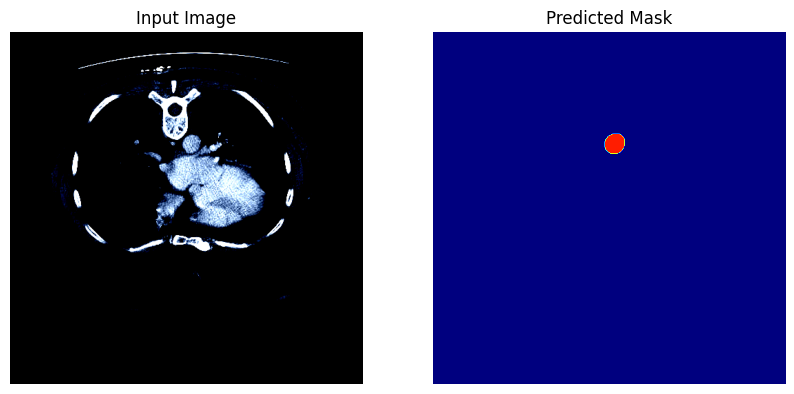

In [16]:
# Load your trained model
model.load_state_dict(torch.load('unet_res34_16_noinv_inv_jitter_phase2.pth', map_location=device))

# Test image path
img_test_path = 'train_images/train_1286.png'  # Adjust path as needed
predicted_mask = test_single(img_test_path, model, device)